In [1]:
import numpy as np
from optic.torchUtils import slidingWindowDataSet, MLP
import torch
from torch import nn
from torch.utils.data import DataLoader
from torch.utils.data import Dataset, ConcatDataset
from optic.comm.modulation import GrayMapping, modulateGray, demodulateGray
from optic.dsp.core import pulseShape, lowPassFIR, pnorm, signal_power
from optic.utils import parameters, dBm2W
from optic.models.devices import mzm, photodiode, edfa
from optic.comm.modulation import GrayMapping, modulateGray, demodulateGray

from tqdm.notebook import tqdm
from commpy.utilities  import upsample
from optic.dsp.core import firFilter
from optic.models.channels import linearFiberChannel
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split

import os
os.environ['KMP_DUPLICATE_LIB_OK'] = 'True'

In [2]:
import OpticFunctions as of
import importlib
import IPython.display as ipd

In [3]:
from IPython.core.display import HTML
from IPython.core.pylabtools import figsize

figsize(10, 3)

In [4]:
np.random.seed(seed=123)

In [5]:
# Parâmetros para geração de sinal
SpS = 2
Rs = 40*10**9
M = 8
num_symbs = 5e3
dist_fibra = 8

In [6]:
sinaltx, symbtx = of.SimulaSinalOptico(SpS = SpS, Rs = Rs, M = M, num_symbs = num_symbs)

SymbTx antes da normalização:  [-1. -7. -3. ...  7. -3. -5.]


In [7]:
sinalrx = of.SimulaCanalOptico(sinal = sinaltx, SpS = SpS, Rs = Rs, dist_fibra = dist_fibra)

Number of counted errors = 5194 
BER = 3.51e-01 


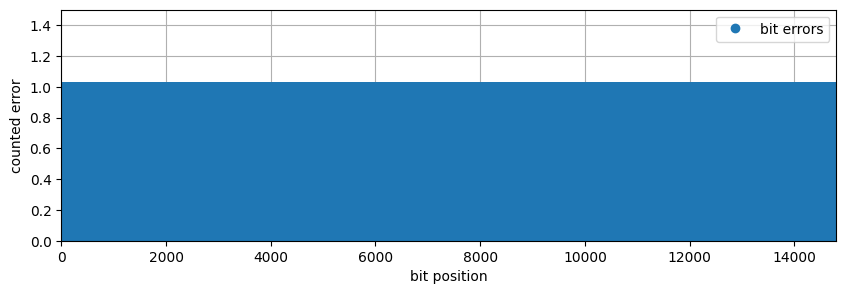

In [8]:
bits_tx = of.RecuperaBits(sinaltx, SpS, M)
bits_rx = of.RecuperaBits(sinalrx, SpS, M)
of.CalculaBER(bits_tx, bits_rx)

In [9]:
Ntaps = 2
batch_size = 100
shuffle = True
shuffle_full = False

train_dataset, test_dataset, full_dataset = of.CriaDataSet(symbtx, sinalrx, SpS, Ntaps = Ntaps)

train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=shuffle)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=shuffle)
full_dataloader = DataLoader(full_dataset, batch_size=len(full_dataset), shuffle=shuffle_full)

In [10]:
modelo_mlp = MLP([2, 3, 2, 1])

In [11]:
loss_fn = nn.MSELoss()
epochs_mlp = 100
optimizer = torch.optim.Adam(modelo_mlp.parameters(), lr = 0.0005)
cada_print = 50

for t in range(epochs_mlp):
    print(f"Época {t+1}\n-------------------------------")
    of.train_loop(train_dataloader, modelo_mlp, loss_fn, optimizer, cada_print)
    of.test_loop(test_dataloader, modelo_mlp, loss_fn)
print("Pronto!")

framerate = 44100
t = np.linspace(0,1,framerate*1)
data = np.sin(2*np.pi*220*t) + np.sin(2*np.pi*224*t)
ipd.Audio(data,rate=framerate, autoplay=True)

Época 1
-------------------------------
loss: 1.667754[  100/ 4000]
Perda média: 1.266621 

Época 2
-------------------------------
loss: 1.391204[  100/ 4000]
Perda média: 1.219606 

Época 3
-------------------------------
loss: 1.116460[  100/ 4000]
Perda média: 1.180852 

Época 4
-------------------------------
loss: 1.186394[  100/ 4000]
Perda média: 1.143546 

Época 5
-------------------------------
loss: 1.521275[  100/ 4000]
Perda média: 1.104830 

Época 6
-------------------------------
loss: 1.016596[  100/ 4000]
Perda média: 1.065867 

Época 7
-------------------------------
loss: 1.211647[  100/ 4000]
Perda média: 1.025688 

Época 8
-------------------------------
loss: 1.036710[  100/ 4000]
Perda média: 0.980327 

Época 9
-------------------------------
loss: 0.820297[  100/ 4000]
Perda média: 0.936574 

Época 10
-------------------------------
loss: 1.056218[  100/ 4000]
Perda média: 0.893353 

Época 11
-------------------------------
loss: 0.853253[  100/ 4000]
Perda médi

loss: 0.178496[  100/ 4000]
Perda média: 0.163142 

Época 90
-------------------------------
loss: 0.143828[  100/ 4000]
Perda média: 0.163187 

Época 91
-------------------------------
loss: 0.160613[  100/ 4000]
Perda média: 0.163274 

Época 92
-------------------------------
loss: 0.175853[  100/ 4000]
Perda média: 0.163141 

Época 93
-------------------------------
loss: 0.190870[  100/ 4000]
Perda média: 0.163238 

Época 94
-------------------------------
loss: 0.198456[  100/ 4000]
Perda média: 0.163166 

Época 95
-------------------------------
loss: 0.204673[  100/ 4000]
Perda média: 0.163134 

Época 96
-------------------------------
loss: 0.167209[  100/ 4000]
Perda média: 0.163230 

Época 97
-------------------------------
loss: 0.166231[  100/ 4000]
Perda média: 0.163136 

Época 98
-------------------------------
loss: 0.189797[  100/ 4000]
Perda média: 0.163195 

Época 99
-------------------------------
loss: 0.154182[  100/ 4000]
Perda média: 0.163287 

Época 100
--------

In [12]:
torch.save(modelo_mlp, 'PrimeModel.pth')

In [13]:
#modelo_mlp = torch.load('PrimeModel.pth')

Number of counted errors = 3467 
BER = 2.34e-01 


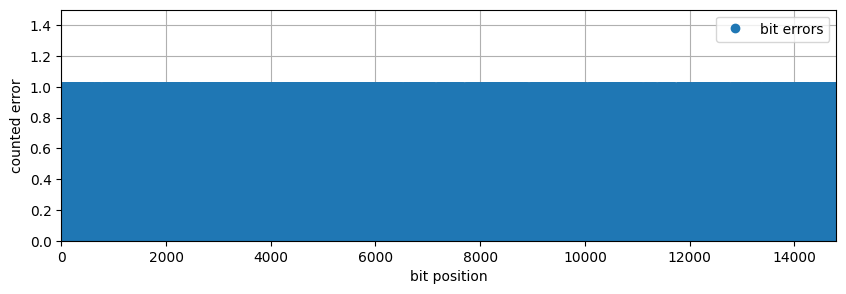

In [14]:
symb_mlp = of.GeraSinalEqualizado(modelo_mlp, full_dataloader)
const = GrayMapping(M, 'pam') 
Es = signal_power(const)
#print(symb_rx_nn.shape)
bitsrx = demodulateGray(np.sqrt(Es)*pnorm(symb_mlp), M, 'pam')
bitstx = demodulateGray(np.sqrt(Es)*pnorm(symbtx), M, 'pam')

of.CalculaBER(bitstx, bitsrx)

# Treinamento das redes clone para outras distâncias de transmissão

### Estruturação dos conjuntos de dados

In [15]:
sinalt4, symbt4 = of.SimulaSinalOptico(SpS = SpS, Rs = Rs, M = M, num_symbs = num_symbs)
sinalt6, symbt6 = of.SimulaSinalOptico(SpS = SpS, Rs = Rs, M = M, num_symbs = num_symbs)
sinalt10, symbt10 = of.SimulaSinalOptico(SpS = SpS, Rs = Rs, M = M, num_symbs = num_symbs)
sinalt12, symbt12 = of.SimulaSinalOptico(SpS = SpS, Rs = Rs, M = M, num_symbs = num_symbs)

SymbTx antes da normalização:  [ 1. -7.  5. ... -3. -3. -7.]
SymbTx antes da normalização:  [-5. -7.  1. ...  3.  1. -3.]
SymbTx antes da normalização:  [ 3. -1.  5. ... -7.  3. -1.]
SymbTx antes da normalização:  [-5.  3. -5. ...  3.  1.  1.]


In [16]:
sinalr4 = of.SimulaCanalOptico(sinal = sinalt4, SpS = SpS, Rs = Rs, dist_fibra = 4)
sinalr6 = of.SimulaCanalOptico(sinal = sinalt6, SpS = SpS, Rs = Rs, dist_fibra = 6)
sinalr10 = of.SimulaCanalOptico(sinal = sinalt10, SpS = SpS, Rs = Rs, dist_fibra = 10)
sinalr12 = of.SimulaCanalOptico(sinal = sinalt12, SpS = SpS, Rs = Rs, dist_fibra = 12)

In [17]:
train_dataset4, test_dataset4, full_dataset4 = of.CriaDataSet(symbt4, sinalr4, SpS, Ntaps = Ntaps)

train_dataloader4 = DataLoader(train_dataset4, batch_size=batch_size, shuffle=shuffle)
test_dataloader4 = DataLoader(test_dataset4, batch_size=batch_size, shuffle=shuffle)
full_dataloader4 = DataLoader(full_dataset4, batch_size=len(full_dataset), shuffle=shuffle_full)


train_dataset6, test_dataset6, full_dataset6 = of.CriaDataSet(symbt6, sinalr6, SpS, Ntaps = Ntaps)

train_dataloader6 = DataLoader(train_dataset6, batch_size=batch_size, shuffle=shuffle)
test_dataloader6 = DataLoader(test_dataset6, batch_size=batch_size, shuffle=shuffle)
full_dataloader6 = DataLoader(full_dataset6, batch_size=len(full_dataset), shuffle=shuffle_full)


train_dataset10, test_dataset10, full_dataset10 = of.CriaDataSet(symbt10, sinalr10, SpS, Ntaps = Ntaps)

train_dataloader10 = DataLoader(train_dataset10, batch_size=batch_size, shuffle=shuffle)
test_dataloader10 = DataLoader(test_dataset10, batch_size=batch_size, shuffle=shuffle)
full_dataloader10 = DataLoader(full_dataset10, batch_size=len(full_dataset), shuffle=shuffle_full)


train_dataset12, test_dataset12, full_dataset12 = of.CriaDataSet(symbt12, sinalr12, SpS, Ntaps = Ntaps)

train_dataloader12 = DataLoader(train_dataset12, batch_size=batch_size, shuffle=shuffle)
test_dataloader12 = DataLoader(test_dataset12, batch_size=batch_size, shuffle=shuffle)
full_dataloader12 = DataLoader(full_dataset12, batch_size=len(full_dataset), shuffle=shuffle_full)

### Criação de modelos, hiperparâmetros e função de teste

In [18]:
model_test = MLP([2, 3, 2, 1])

In [19]:
model4 = torch.load('PrimeModel.pth')
model6 = torch.load('PrimeModel.pth')
model10 = torch.load('PrimeModel.pth')
model12 = torch.load('PrimeModel.pth')

In [20]:
loss_fn = nn.MSELoss()
epochs_mlp = 40
cada_print = 10

optimizer_test = torch.optim.Adam(model_test.parameters(),  lr = 0.0005)
optimizer4 = torch.optim.Adam(model4.parameters(), lr = 0.0005)
optimizer6 = torch.optim.Adam(model6.parameters(), lr = 0.0005)
optimizer10 = torch.optim.Adam(model10.parameters(), lr = 0.0005)

In [21]:
def test_learning(progress_dataloader, equalizer, loss, loss_list):
    size = len(progress_dataloader.dataset)
    num_batches = len(progress_dataloader)
    equalizer.eval()
    eval_loss = 0
    with torch.no_grad():
        for x, y in progress_dataloader:
            x, y = x.float(), y.float()
            pred = equalizer(x)
            eval_loss += loss(pred, y).item()
    eval_loss /= num_batches
    loss_list.append(eval_loss)
    print(f"Perda média: {eval_loss:>8f} \n")
    return loss_list

## Comparação entre modelos para 4 km

In [22]:
loss_list = []

for t in range(epochs_mlp):
    print(f"Época {t+1}\n-------------------------------")
    of.train_loop(train_dataloader4, model4, loss_fn, optimizer4, cada_print)
    loss_list4 = test_learning(test_dataloader4, model4, loss_fn, loss_list)
print("Pronto!")

framerate = 44100
t = np.linspace(0,1,framerate*1)
data = np.sin(2*np.pi*220*t) + np.sin(2*np.pi*224*t)
ipd.Audio(data,rate=framerate, autoplay=True)

Época 1
-------------------------------
loss: 0.047256[  100/ 4000]
loss: 0.053550[ 1100/ 4000]
loss: 0.033933[ 2100/ 4000]
loss: 0.058985[ 3100/ 4000]
Perda média: 0.045496 

Época 2
-------------------------------
loss: 0.044871[  100/ 4000]
loss: 0.041148[ 1100/ 4000]
loss: 0.045351[ 2100/ 4000]
loss: 0.043012[ 3100/ 4000]
Perda média: 0.040884 

Época 3
-------------------------------
loss: 0.038921[  100/ 4000]
loss: 0.041151[ 1100/ 4000]
loss: 0.038153[ 2100/ 4000]
loss: 0.046323[ 3100/ 4000]
Perda média: 0.038159 

Época 4
-------------------------------
loss: 0.040393[  100/ 4000]
loss: 0.040576[ 1100/ 4000]
loss: 0.042179[ 2100/ 4000]
loss: 0.043593[ 3100/ 4000]
Perda média: 0.036838 

Época 5
-------------------------------
loss: 0.035945[  100/ 4000]
loss: 0.028243[ 1100/ 4000]
loss: 0.026292[ 2100/ 4000]
loss: 0.030007[ 3100/ 4000]
Perda média: 0.035475 

Época 6
-------------------------------
loss: 0.034493[  100/ 4000]
loss: 0.031684[ 1100/ 4000]
loss: 0.034754[ 2100/ 40

In [23]:
loss_list_test = []
for t in range(epochs_mlp):
    print(f"Época {t+1}\n-------------------------------")
    of.train_loop(train_dataloader4, model_test, loss_fn, optimizer_test, cada_print)
    loss_listnl = test_learning(test_dataloader4, model_test, loss_fn, loss_list_test)
print("Pronto!")

framerate = 44100
t = np.linspace(0,1,framerate*1)
data = np.sin(2*np.pi*220*t) + np.sin(2*np.pi*224*t)
ipd.Audio(data,rate=framerate, autoplay=True)

Época 1
-------------------------------
loss: 1.338331[  100/ 4000]
loss: 1.087681[ 1100/ 4000]
loss: 1.184649[ 2100/ 4000]
loss: 1.089420[ 3100/ 4000]
Perda média: 1.177425 

Época 2
-------------------------------
loss: 1.076434[  100/ 4000]
loss: 1.061941[ 1100/ 4000]
loss: 1.373473[ 2100/ 4000]
loss: 1.203932[ 3100/ 4000]
Perda média: 1.138348 

Época 3
-------------------------------
loss: 1.222356[  100/ 4000]
loss: 1.041158[ 1100/ 4000]
loss: 1.100100[ 2100/ 4000]
loss: 1.099313[ 3100/ 4000]
Perda média: 1.106712 

Época 4
-------------------------------
loss: 1.030985[  100/ 4000]
loss: 1.215297[ 1100/ 4000]
loss: 1.074877[ 2100/ 4000]
loss: 1.033117[ 3100/ 4000]
Perda média: 1.080422 

Época 5
-------------------------------
loss: 1.009231[  100/ 4000]
loss: 1.132890[ 1100/ 4000]
loss: 1.236291[ 2100/ 4000]
loss: 0.920362[ 3100/ 4000]
Perda média: 1.058037 

Época 6
-------------------------------
loss: 1.215778[  100/ 4000]
loss: 1.168103[ 1100/ 4000]
loss: 0.973741[ 2100/ 40

In [24]:
loss_prime = []
for t in range(40):
    prime_list = test_learning(test_dataloader4, modelo_mlp, loss_fn, loss_prime)

Perda média: 0.053242 

Perda média: 0.053242 

Perda média: 0.053242 

Perda média: 0.053242 

Perda média: 0.053242 

Perda média: 0.053242 

Perda média: 0.053242 

Perda média: 0.053242 

Perda média: 0.053242 

Perda média: 0.053242 

Perda média: 0.053242 

Perda média: 0.053242 

Perda média: 0.053242 

Perda média: 0.053242 

Perda média: 0.053242 

Perda média: 0.053242 

Perda média: 0.053242 

Perda média: 0.053242 

Perda média: 0.053242 

Perda média: 0.053242 

Perda média: 0.053242 

Perda média: 0.053242 

Perda média: 0.053242 

Perda média: 0.053242 

Perda média: 0.053242 

Perda média: 0.053242 

Perda média: 0.053242 

Perda média: 0.053242 

Perda média: 0.053242 

Perda média: 0.053242 

Perda média: 0.053242 

Perda média: 0.053242 

Perda média: 0.053242 

Perda média: 0.053242 

Perda média: 0.053242 

Perda média: 0.053242 

Perda média: 0.053242 

Perda média: 0.053242 

Perda média: 0.053242 

Perda média: 0.053242 



Text(0, 0.5, 'loss')

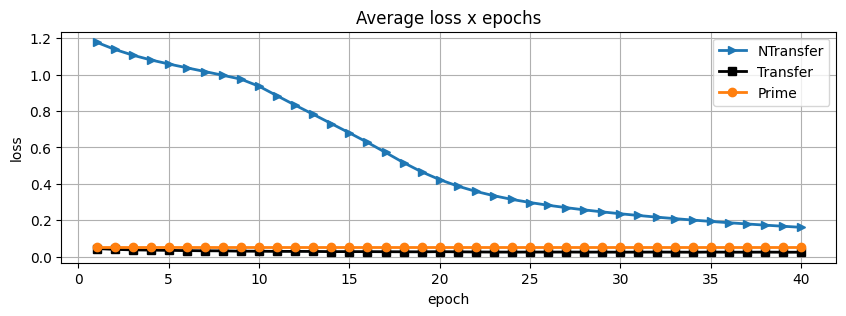

In [25]:
epocas = list(range(1, 41))
plt.plot(epocas, loss_listnl,'>-', label='NTransfer',linewidth = 2)
plt.plot(epocas, loss_list4,'-s', label='Transfer', color = 'black', linewidth = 2)
plt.plot(epocas, loss_prime, '-o', label = 'Prime', linewidth = 2)
plt.grid()
plt.legend();
plt.title('Average loss x epochs')
plt.xlabel('epoch')
plt.ylabel('loss')

In [26]:
discard = 100
power = np.arange(-15, 0)
BER4 = np.zeros(power.size)
BER_NN4 = np.zeros(power.size)
BER_NNC4 = np.zeros(power.size)
SpS_out = 1
Ntaps = 2

for ind, Pin in enumerate(power):
    sinaltx4, symbtx4 = of.SimulaSinalOptico(SpS = SpS, Rs = Rs, M = M, Pi_dBm = Pin, num_symbs = 1e5)
    
    irx4 = of.SimulaCanalOptico(sinaltx4, SpS = SpS, Rs = Rs, dist_fibra = 4)
    
    bitsTx4 = of.RecuperaBits(sinaltx4, SpS, M)
    bitsRx4 = of.RecuperaBits(irx4, SpS, M)
    
    err = np.logical_xor(bitsRx4[discard:bitsRx4.size-discard], bitsTx4[discard:bitsTx4.size-discard])
    BER4[ind] = np.mean(err)
    
    print('BER = %.2e '%(BER4[ind]))
    
    signalrx4 = pnorm(irx4[0::SpS//SpS_out])
    signalrx4= (signalrx4 - np.mean(signalrx4))/np.std(signalrx4)
    
    dataset4 = slidingWindowDataSet(signalrx4, symbtx4, Ntaps, SpS_out)
    
    dataloader4 = DataLoader(dataset4, batch_size=len(dataset4), shuffle=False)

    symb_NN4 = of.GeraSinalEqualizado(model_test, dataloader4)

    bitsRxNN4 = demodulateGray(np.sqrt(Es)*pnorm(symb_NN4), M, 'pam')

    #discard = 1000
    err = np.logical_xor(bitsRxNN4[discard:bitsRxNN4.size-discard], bitsTx4[discard:bitsTx4.size-discard])
    BER_NN4[ind] = np.mean(err)

    #Pb = 0.5*erfc(Q/np.sqrt(2)) # theoretical error probability
    print('BER_NN = %.2e '%(BER_NN4[ind]))
    
    symb_NNC4 = of.GeraSinalEqualizado(model4, dataloader4)
    
    bitsRxNNC4 = demodulateGray(np.sqrt(Es)*pnorm(symb_NNC4), M, 'pam')

    #discard = 1000
    err = np.logical_xor(bitsRxNNC4[discard:bitsRxNNC4.size-discard], bitsTx4[discard:bitsTx4.size-discard])
    BER_NNC4[ind] = np.mean(err)

    #Pb = 0.5*erfc(Q/np.sqrt(2)) # theoretical error probability
    print('BER_NN = %.2e '%(BER_NNC4[ind]))

SymbTx antes da normalização:  [ 1. -1. -1. ... -3. -7.  7.]
BER = 2.70e-01 
BER_NN = 2.56e-01 
BER_NN = 2.38e-01 
SymbTx antes da normalização:  [7. 1. 1. ... 3. 5. 5.]
BER = 2.50e-01 
BER_NN = 2.32e-01 
BER_NN = 2.03e-01 
SymbTx antes da normalização:  [ 3.  5.  3. ...  3. -5. -5.]
BER = 2.34e-01 
BER_NN = 2.12e-01 
BER_NN = 1.71e-01 
SymbTx antes da normalização:  [ 5. -3.  7. ...  7. -7.  1.]
BER = 2.22e-01 
BER_NN = 1.97e-01 
BER_NN = 1.46e-01 
SymbTx antes da normalização:  [-5. -3. -5. ...  3. -1. -3.]
BER = 2.15e-01 
BER_NN = 1.88e-01 
BER_NN = 1.25e-01 
SymbTx antes da normalização:  [ 5. -1.  1. ... -3.  1. -7.]
BER = 2.11e-01 
BER_NN = 1.83e-01 
BER_NN = 1.10e-01 
SymbTx antes da normalização:  [-7.  1.  7. ... -3. -1.  7.]
BER = 2.08e-01 
BER_NN = 1.79e-01 
BER_NN = 9.64e-02 
SymbTx antes da normalização:  [-3. -5.  7. ...  7.  7.  1.]
BER = 2.07e-01 
BER_NN = 1.77e-01 
BER_NN = 8.77e-02 
SymbTx antes da normalização:  [ 1. -7. -5. ... -3. -3. -1.]
BER = 2.06e-01 
BER_NN = 

Text(0, 0.5, 'log10(BER)')

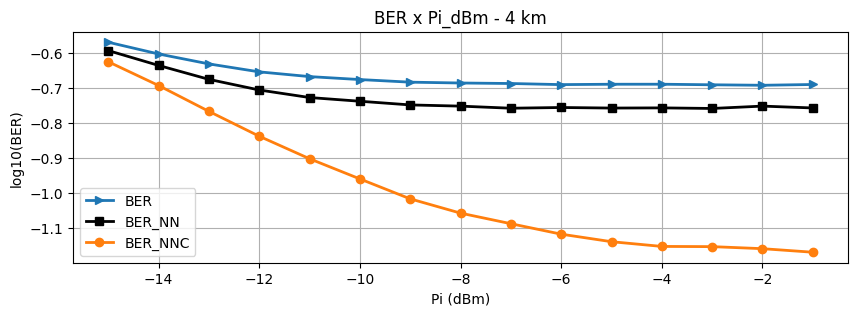

In [27]:
plt.plot(power, np.log10(BER4),'>-', label='BER',linewidth = 2)
plt.plot(power, np.log10(BER_NN4),'-s', label='BER_NN', color = 'black', linewidth = 2)
plt.plot(power, np.log10(BER_NNC4), '-o', label = 'BER_NNC', linewidth = 2)
plt.grid()
plt.legend();
plt.title('BER x Pi_dBm - 4 km')
plt.xlabel('Pi (dBm)')
plt.ylabel('log10(BER)')

## Comparação entre modelos para 6 km

In [28]:
model_test = MLP([2, 3, 2, 1])
optimizer_test = torch.optim.Adam(model_test.parameters(),  lr = 0.0005)

In [29]:
loss_list = []

for t in range(epochs_mlp):
    print(f"Época {t+1}\n-------------------------------")
    of.train_loop(train_dataloader6, model6, loss_fn, optimizer6, cada_print)
    loss_list6 = test_learning(test_dataloader6, model6, loss_fn, loss_list)
print("Pronto!")

Época 1
-------------------------------
loss: 0.077251[  100/ 4000]
loss: 0.077359[ 1100/ 4000]
loss: 0.097250[ 2100/ 4000]
loss: 0.083872[ 3100/ 4000]
Perda média: 0.069691 

Época 2
-------------------------------
loss: 0.073145[  100/ 4000]
loss: 0.062530[ 1100/ 4000]
loss: 0.068676[ 2100/ 4000]
loss: 0.063129[ 3100/ 4000]
Perda média: 0.067704 

Época 3
-------------------------------
loss: 0.076842[  100/ 4000]
loss: 0.078903[ 1100/ 4000]
loss: 0.074443[ 2100/ 4000]
loss: 0.063642[ 3100/ 4000]
Perda média: 0.067089 

Época 4
-------------------------------
loss: 0.077063[  100/ 4000]
loss: 0.069917[ 1100/ 4000]
loss: 0.070925[ 2100/ 4000]
loss: 0.071628[ 3100/ 4000]
Perda média: 0.066465 

Época 5
-------------------------------
loss: 0.069017[  100/ 4000]
loss: 0.067786[ 1100/ 4000]
loss: 0.067235[ 2100/ 4000]
loss: 0.068168[ 3100/ 4000]
Perda média: 0.066030 

Época 6
-------------------------------
loss: 0.079276[  100/ 4000]
loss: 0.076135[ 1100/ 4000]
loss: 0.073613[ 2100/ 40

In [30]:
loss_list_test = []
for t in range(epochs_mlp):
    print(f"Época {t+1}\n-------------------------------")
    of.train_loop(train_dataloader6, model_test, loss_fn, optimizer_test, cada_print)
    loss_listnl = test_learning(test_dataloader6, model_test, loss_fn, loss_list_test)
print("Pronto!")


Época 1
-------------------------------
loss: 1.287291[  100/ 4000]
loss: 1.404460[ 1100/ 4000]
loss: 1.200868[ 2100/ 4000]
loss: 1.581354[ 3100/ 4000]
Perda média: 1.405926 

Época 2
-------------------------------
loss: 1.414310[  100/ 4000]
loss: 1.247936[ 1100/ 4000]
loss: 1.236343[ 2100/ 4000]
loss: 1.061693[ 3100/ 4000]
Perda média: 1.346101 

Época 3
-------------------------------
loss: 1.508432[  100/ 4000]
loss: 1.164962[ 1100/ 4000]
loss: 1.373835[ 2100/ 4000]
loss: 1.265404[ 3100/ 4000]
Perda média: 1.292627 

Época 4
-------------------------------
loss: 1.261582[  100/ 4000]
loss: 1.340194[ 1100/ 4000]
loss: 1.136709[ 2100/ 4000]
loss: 1.392343[ 3100/ 4000]
Perda média: 1.242333 

Época 5
-------------------------------
loss: 1.155903[  100/ 4000]
loss: 1.089898[ 1100/ 4000]
loss: 1.188382[ 2100/ 4000]
loss: 1.229464[ 3100/ 4000]
Perda média: 1.197047 

Época 6
-------------------------------
loss: 1.144642[  100/ 4000]
loss: 0.924594[ 1100/ 4000]
loss: 1.108993[ 2100/ 40

In [31]:
loss_prime = []
for t in range(40):
    prime_list = test_learning(test_dataloader6, modelo_mlp, loss_fn, loss_prime)

Perda média: 0.072794 

Perda média: 0.072794 

Perda média: 0.072794 

Perda média: 0.072794 

Perda média: 0.072794 

Perda média: 0.072794 

Perda média: 0.072794 

Perda média: 0.072794 

Perda média: 0.072794 

Perda média: 0.072794 

Perda média: 0.072794 

Perda média: 0.072794 

Perda média: 0.072794 

Perda média: 0.072794 

Perda média: 0.072794 

Perda média: 0.072794 

Perda média: 0.072794 

Perda média: 0.072794 

Perda média: 0.072794 

Perda média: 0.072794 

Perda média: 0.072794 

Perda média: 0.072794 

Perda média: 0.072794 

Perda média: 0.072794 

Perda média: 0.072794 

Perda média: 0.072794 

Perda média: 0.072794 

Perda média: 0.072794 

Perda média: 0.072794 

Perda média: 0.072794 

Perda média: 0.072794 

Perda média: 0.072794 

Perda média: 0.072794 

Perda média: 0.072794 

Perda média: 0.072794 

Perda média: 0.072794 

Perda média: 0.072794 

Perda média: 0.072794 

Perda média: 0.072794 

Perda média: 0.072794 



Text(0, 0.5, 'loss')

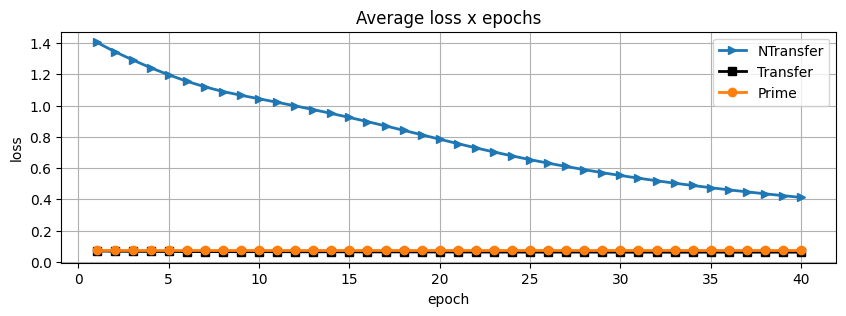

In [32]:
epocas = list(range(1, 41))
plt.plot(epocas, loss_listnl,'>-', label='NTransfer',linewidth = 2)
plt.plot(epocas, loss_list6,'-s', label='Transfer', color = 'black', linewidth = 2)
plt.plot(epocas, prime_list, '-o', label = 'Prime', linewidth = 2)
plt.grid()
plt.legend();
plt.title('Average loss x epochs')
plt.xlabel('epoch')
plt.ylabel('loss')

## Comparação entre modelos para 10 km

In [33]:
model_test = MLP([2, 3, 2, 1])
optimizer_test = torch.optim.Adam(model_test.parameters(),  lr = 0.0005)

In [34]:
loss_list = []
epochs10 = 60

for t in range(epochs10):
    print(f"Época {t+1}\n-------------------------------")
    of.train_loop(train_dataloader10, model10, loss_fn, optimizer10, cada_print)
    loss_list10 = test_learning(test_dataloader10, model10, loss_fn, loss_list)
print("Pronto!")

Época 1
-------------------------------
loss: 0.360713[  100/ 4000]
loss: 0.309254[ 1100/ 4000]
loss: 0.300303[ 2100/ 4000]
loss: 0.370433[ 3100/ 4000]
Perda média: 0.356402 

Época 2
-------------------------------
loss: 0.387290[  100/ 4000]
loss: 0.424393[ 1100/ 4000]
loss: 0.397769[ 2100/ 4000]
loss: 0.333567[ 3100/ 4000]
Perda média: 0.354444 

Época 3
-------------------------------
loss: 0.331390[  100/ 4000]
loss: 0.305597[ 1100/ 4000]
loss: 0.298140[ 2100/ 4000]
loss: 0.268477[ 3100/ 4000]
Perda média: 0.354126 

Época 4
-------------------------------
loss: 0.351390[  100/ 4000]
loss: 0.285731[ 1100/ 4000]
loss: 0.270709[ 2100/ 4000]
loss: 0.339166[ 3100/ 4000]
Perda média: 0.352940 

Época 5
-------------------------------
loss: 0.380279[  100/ 4000]
loss: 0.318567[ 1100/ 4000]
loss: 0.334572[ 2100/ 4000]
loss: 0.351212[ 3100/ 4000]
Perda média: 0.353184 

Época 6
-------------------------------
loss: 0.309950[  100/ 4000]
loss: 0.323747[ 1100/ 4000]
loss: 0.281500[ 2100/ 40

loss: 0.386429[ 2100/ 4000]
loss: 0.297921[ 3100/ 4000]
Perda média: 0.350919 

Época 48
-------------------------------
loss: 0.355832[  100/ 4000]
loss: 0.322904[ 1100/ 4000]
loss: 0.359130[ 2100/ 4000]
loss: 0.270736[ 3100/ 4000]
Perda média: 0.350565 

Época 49
-------------------------------
loss: 0.340621[  100/ 4000]
loss: 0.371550[ 1100/ 4000]
loss: 0.278034[ 2100/ 4000]
loss: 0.336283[ 3100/ 4000]
Perda média: 0.350038 

Época 50
-------------------------------
loss: 0.333470[  100/ 4000]
loss: 0.330193[ 1100/ 4000]
loss: 0.329276[ 2100/ 4000]
loss: 0.301752[ 3100/ 4000]
Perda média: 0.350177 

Época 51
-------------------------------
loss: 0.289391[  100/ 4000]
loss: 0.361983[ 1100/ 4000]
loss: 0.356427[ 2100/ 4000]
loss: 0.399357[ 3100/ 4000]
Perda média: 0.350386 

Época 52
-------------------------------
loss: 0.302972[  100/ 4000]
loss: 0.346648[ 1100/ 4000]
loss: 0.434130[ 2100/ 4000]
loss: 0.291307[ 3100/ 4000]
Perda média: 0.350239 

Época 53
--------------------------

In [35]:
loss_list_test = []
for t in range(epochs10):
    print(f"Época {t+1}\n-------------------------------")
    of.train_loop(train_dataloader10, model_test, loss_fn, optimizer_test, cada_print)
    loss_listnl = test_learning(test_dataloader10, model_test, loss_fn, loss_list_test)
print("Pronto!")

Época 1
-------------------------------
loss: 1.171921[  100/ 4000]
loss: 1.113492[ 1100/ 4000]
loss: 1.091209[ 2100/ 4000]
loss: 1.094839[ 3100/ 4000]
Perda média: 1.116928 

Época 2
-------------------------------
loss: 1.158527[  100/ 4000]
loss: 1.105686[ 1100/ 4000]
loss: 1.000807[ 2100/ 4000]
loss: 1.221017[ 3100/ 4000]
Perda média: 1.097198 

Época 3
-------------------------------
loss: 1.121760[  100/ 4000]
loss: 1.076562[ 1100/ 4000]
loss: 1.079172[ 2100/ 4000]
loss: 0.973325[ 3100/ 4000]
Perda média: 1.082218 

Época 4
-------------------------------
loss: 0.956616[  100/ 4000]
loss: 0.956015[ 1100/ 4000]
loss: 1.066567[ 2100/ 4000]
loss: 1.070446[ 3100/ 4000]
Perda média: 1.070530 

Época 5
-------------------------------
loss: 1.123839[  100/ 4000]
loss: 0.958863[ 1100/ 4000]
loss: 0.819451[ 2100/ 4000]
loss: 1.147117[ 3100/ 4000]
Perda média: 1.061189 

Época 6
-------------------------------
loss: 0.984456[  100/ 4000]
loss: 0.949823[ 1100/ 4000]
loss: 0.985239[ 2100/ 40

loss: 0.408760[ 1100/ 4000]
loss: 0.398193[ 2100/ 4000]
loss: 0.455734[ 3100/ 4000]
Perda média: 0.436905 

Época 48
-------------------------------
loss: 0.376882[  100/ 4000]
loss: 0.375162[ 1100/ 4000]
loss: 0.394692[ 2100/ 4000]
loss: 0.397703[ 3100/ 4000]
Perda média: 0.433301 

Época 49
-------------------------------
loss: 0.376919[  100/ 4000]
loss: 0.557807[ 1100/ 4000]
loss: 0.360685[ 2100/ 4000]
loss: 0.451248[ 3100/ 4000]
Perda média: 0.429322 

Época 50
-------------------------------
loss: 0.353553[  100/ 4000]
loss: 0.398033[ 1100/ 4000]
loss: 0.391605[ 2100/ 4000]
loss: 0.414995[ 3100/ 4000]
Perda média: 0.426370 

Época 51
-------------------------------
loss: 0.393289[  100/ 4000]
loss: 0.444670[ 1100/ 4000]
loss: 0.393540[ 2100/ 4000]
loss: 0.363164[ 3100/ 4000]
Perda média: 0.423426 

Época 52
-------------------------------
loss: 0.433004[  100/ 4000]
loss: 0.321536[ 1100/ 4000]
loss: 0.362702[ 2100/ 4000]
loss: 0.407162[ 3100/ 4000]
Perda média: 0.420147 

Época 5

In [36]:
loss_prime = []
for t in range(60):
    prime_list = test_learning(test_dataloader10, modelo_mlp, loss_fn, loss_prime)

Perda média: 0.361893 

Perda média: 0.361893 

Perda média: 0.361893 

Perda média: 0.361893 

Perda média: 0.361893 

Perda média: 0.361893 

Perda média: 0.361893 

Perda média: 0.361893 

Perda média: 0.361893 

Perda média: 0.361893 

Perda média: 0.361893 

Perda média: 0.361893 

Perda média: 0.361893 

Perda média: 0.361893 

Perda média: 0.361893 

Perda média: 0.361893 

Perda média: 0.361893 

Perda média: 0.361893 

Perda média: 0.361893 

Perda média: 0.361893 

Perda média: 0.361893 

Perda média: 0.361893 

Perda média: 0.361893 

Perda média: 0.361893 

Perda média: 0.361893 

Perda média: 0.361893 

Perda média: 0.361893 

Perda média: 0.361893 

Perda média: 0.361893 

Perda média: 0.361893 

Perda média: 0.361893 

Perda média: 0.361893 

Perda média: 0.361893 

Perda média: 0.361893 

Perda média: 0.361893 

Perda média: 0.361893 

Perda média: 0.361893 

Perda média: 0.361893 

Perda média: 0.361893 

Perda média: 0.361893 

Perda média: 0.361893 

Perda média: 0.3

Text(0, 0.5, 'loss')

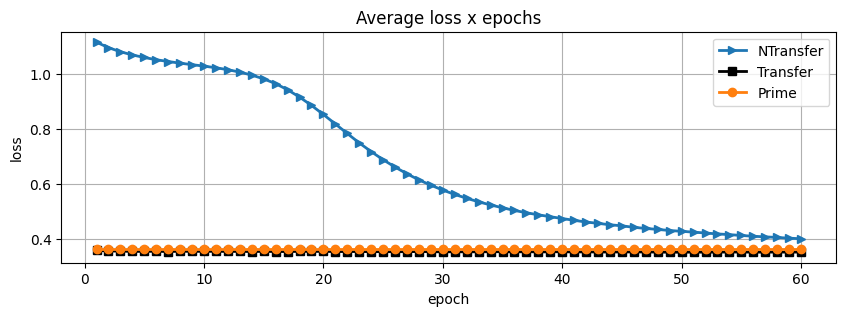

In [37]:
epocas = list(range(1, 61))
plt.plot(epocas, loss_listnl,'>-', label='NTransfer',linewidth = 2)
plt.plot(epocas, loss_list10,'-s', label='Transfer', color = 'black', linewidth = 2)
plt.plot(epocas, loss_prime, '-o', label = 'Prime', linewidth = 2)
plt.grid()
plt.legend();
plt.title('Average loss x epochs')
plt.xlabel('epoch')
plt.ylabel('loss')

In [38]:
discard = 100
power = np.arange(-15, 0)
BER4 = np.zeros(power.size)
BER_NN4 = np.zeros(power.size)
BER_NNC4 = np.zeros(power.size)
SpS_out = 1
Ntaps = 2

for ind, Pin in enumerate(power):
    sinaltx4, symbtx4 = of.SimulaSinalOptico(SpS = SpS, Rs = Rs, M = M, Pi_dBm = Pin, num_symbs = 1e5)
    
    irx4 = of.SimulaCanalOptico(sinaltx4, SpS = SpS, Rs = Rs, dist_fibra = 10)
    
    bitsTx4 = of.RecuperaBits(sinaltx4, SpS, M)
    bitsRx4 = of.RecuperaBits(irx4, SpS, M)
    
    err = np.logical_xor(bitsRx4[discard:bitsRx4.size-discard], bitsTx4[discard:bitsTx4.size-discard])
    BER4[ind] = np.mean(err)
    
    print('BER = %.2e '%(BER4[ind]))
    
    signalrx4 = pnorm(irx4[0::SpS//SpS_out])
    signalrx4= (signalrx4 - np.mean(signalrx4))/np.std(signalrx4)
    
    dataset4 = slidingWindowDataSet(signalrx4, symbtx4, Ntaps, SpS_out)
    
    dataloader4 = DataLoader(dataset4, batch_size=len(dataset4), shuffle=False)

    symb_NN4 = of.GeraSinalEqualizado(model_test, dataloader4)

    bitsRxNN4 = demodulateGray(np.sqrt(Es)*pnorm(symb_NN4), M, 'pam')

    #discard = 1000
    err = np.logical_xor(bitsRxNN4[discard:bitsRxNN4.size-discard], bitsTx4[discard:bitsTx4.size-discard])
    BER_NN4[ind] = np.mean(err)

    #Pb = 0.5*erfc(Q/np.sqrt(2)) # theoretical error probability
    print('BER_NN = %.2e '%(BER_NN4[ind]))
    
    symb_NNC4 = of.GeraSinalEqualizado(model10, dataloader4)
    
    bitsRxNNC4 = demodulateGray(np.sqrt(Es)*pnorm(symb_NNC4), M, 'pam')

    #discard = 1000
    err = np.logical_xor(bitsRxNNC4[discard:bitsRxNNC4.size-discard], bitsTx4[discard:bitsTx4.size-discard])
    BER_NNC4[ind] = np.mean(err)

    #Pb = 0.5*erfc(Q/np.sqrt(2)) # theoretical error probability
    print('BER_NN = %.2e '%(BER_NNC4[ind]))

SymbTx antes da normalização:  [ 5.  7. -3. ...  7. -3. -1.]
BER = 3.87e-01 
BER_NN = 3.46e-01 
BER_NN = 3.52e-01 
SymbTx antes da normalização:  [ 7. -1. -1. ...  1.  3. -3.]
BER = 3.83e-01 
BER_NN = 3.33e-01 
BER_NN = 3.39e-01 
SymbTx antes da normalização:  [-5.  3. -7. ...  3. -1.  7.]
BER = 3.83e-01 
BER_NN = 3.27e-01 
BER_NN = 3.32e-01 
SymbTx antes da normalização:  [-1. -3. -1. ...  5. -3. -1.]
BER = 3.84e-01 
BER_NN = 3.20e-01 
BER_NN = 3.24e-01 
SymbTx antes da normalização:  [ 3.  7.  1. ... -7.  5.  1.]
BER = 3.86e-01 
BER_NN = 3.18e-01 
BER_NN = 3.20e-01 
SymbTx antes da normalização:  [-3. -3. -5. ...  3. -7. -5.]
BER = 3.88e-01 
BER_NN = 3.15e-01 
BER_NN = 3.18e-01 
SymbTx antes da normalização:  [-3. -5.  1. ... -3.  1. -3.]
BER = 3.87e-01 
BER_NN = 3.14e-01 
BER_NN = 3.15e-01 
SymbTx antes da normalização:  [-1.  3. -1. ... -7. -5. -3.]
BER = 3.89e-01 
BER_NN = 3.13e-01 
BER_NN = 3.15e-01 
SymbTx antes da normalização:  [-3. -7. -5. ... -3. -7.  7.]
BER = 3.88e-01 
BER

Text(0, 0.5, 'log10(BER)')

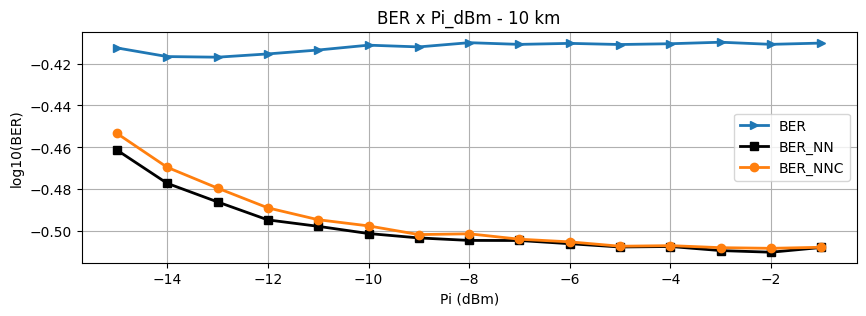

In [39]:
plt.plot(power, np.log10(BER4),'>-', label='BER',linewidth = 2)
plt.plot(power, np.log10(BER_NN4),'-s', label='BER_NN', color = 'black', linewidth = 2)
plt.plot(power, np.log10(BER_NNC4), '-o', label = 'BER_NNC', linewidth = 2)
plt.grid()
plt.legend();
plt.title('BER x Pi_dBm - 10 km')
plt.xlabel('Pi (dBm)')
plt.ylabel('log10(BER)')

## Comparação entre modelos para 12km

In [40]:
model_test = MLP([2, 3, 2, 1])
model12 = torch.load('PrimeModel.pth')

optimizer_test = torch.optim.Adam(model_test.parameters(),  lr = 0.0005)
optimizer12 = torch.optim.Adam(model12.parameters(), lr = 0.0005)

In [41]:
loss_list = []
epochs12 = 60

for t in range(epochs12):
    print(f"Época {t+1}\n-------------------------------")
    of.train_loop(train_dataloader12, model12, loss_fn, optimizer12, cada_print)
    loss_list12 = test_learning(test_dataloader12, model12, loss_fn, loss_list)
print("Pronto!")

Época 1
-------------------------------
loss: 0.643461[  100/ 4000]
loss: 0.497164[ 1100/ 4000]
loss: 0.467707[ 2100/ 4000]
loss: 0.523471[ 3100/ 4000]
Perda média: 0.492482 

Época 2
-------------------------------
loss: 0.529081[  100/ 4000]
loss: 0.431535[ 1100/ 4000]
loss: 0.564174[ 2100/ 4000]
loss: 0.524345[ 3100/ 4000]
Perda média: 0.480389 

Época 3
-------------------------------
loss: 0.538274[  100/ 4000]
loss: 0.484619[ 1100/ 4000]
loss: 0.549680[ 2100/ 4000]
loss: 0.377793[ 3100/ 4000]
Perda média: 0.473730 

Época 4
-------------------------------
loss: 0.546279[  100/ 4000]
loss: 0.440676[ 1100/ 4000]
loss: 0.476172[ 2100/ 4000]
loss: 0.514138[ 3100/ 4000]
Perda média: 0.470673 

Época 5
-------------------------------
loss: 0.493258[  100/ 4000]
loss: 0.529202[ 1100/ 4000]
loss: 0.589358[ 2100/ 4000]
loss: 0.457361[ 3100/ 4000]
Perda média: 0.469013 

Época 6
-------------------------------
loss: 0.463474[  100/ 4000]
loss: 0.459849[ 1100/ 4000]
loss: 0.397210[ 2100/ 40

Perda média: 0.454993 

Época 48
-------------------------------
loss: 0.424029[  100/ 4000]
loss: 0.486631[ 1100/ 4000]
loss: 0.545606[ 2100/ 4000]
loss: 0.390657[ 3100/ 4000]
Perda média: 0.454510 

Época 49
-------------------------------
loss: 0.481359[  100/ 4000]
loss: 0.460771[ 1100/ 4000]
loss: 0.505214[ 2100/ 4000]
loss: 0.497981[ 3100/ 4000]
Perda média: 0.454344 

Época 50
-------------------------------
loss: 0.379197[  100/ 4000]
loss: 0.415516[ 1100/ 4000]
loss: 0.535419[ 2100/ 4000]
loss: 0.448615[ 3100/ 4000]
Perda média: 0.454116 

Época 51
-------------------------------
loss: 0.567524[  100/ 4000]
loss: 0.430780[ 1100/ 4000]
loss: 0.410170[ 2100/ 4000]
loss: 0.377444[ 3100/ 4000]
Perda média: 0.453779 

Época 52
-------------------------------
loss: 0.414272[  100/ 4000]
loss: 0.502070[ 1100/ 4000]
loss: 0.423486[ 2100/ 4000]
loss: 0.520580[ 3100/ 4000]
Perda média: 0.453319 

Época 53
-------------------------------
loss: 0.367746[  100/ 4000]
loss: 0.469308[ 1100/ 

In [42]:
loss_list_test = []
for t in range(epochs12):
    print(f"Época {t+1}\n-------------------------------")
    of.train_loop(train_dataloader12, model_test, loss_fn, optimizer_test, cada_print)
    loss_listnl = test_learning(test_dataloader12, model_test, loss_fn, loss_list_test)
print("Pronto!")

Época 1
-------------------------------
loss: 1.100930[  100/ 4000]
loss: 1.138718[ 1100/ 4000]
loss: 1.148098[ 2100/ 4000]
loss: 0.994793[ 3100/ 4000]
Perda média: 1.019614 

Época 2
-------------------------------
loss: 0.926734[  100/ 4000]
loss: 1.066281[ 1100/ 4000]
loss: 0.923330[ 2100/ 4000]
loss: 0.887835[ 3100/ 4000]
Perda média: 0.988922 

Época 3
-------------------------------
loss: 1.037668[  100/ 4000]
loss: 0.944181[ 1100/ 4000]
loss: 0.941758[ 2100/ 4000]
loss: 0.915184[ 3100/ 4000]
Perda média: 0.961833 

Época 4
-------------------------------
loss: 0.892028[  100/ 4000]
loss: 0.954055[ 1100/ 4000]
loss: 0.848621[ 2100/ 4000]
loss: 1.046560[ 3100/ 4000]
Perda média: 0.933905 

Época 5
-------------------------------
loss: 1.032280[  100/ 4000]
loss: 0.864432[ 1100/ 4000]
loss: 0.784227[ 2100/ 4000]
loss: 0.840818[ 3100/ 4000]
Perda média: 0.908386 

Época 6
-------------------------------
loss: 0.908344[  100/ 4000]
loss: 0.847655[ 1100/ 4000]
loss: 0.895635[ 2100/ 40

loss: 0.520038[  100/ 4000]
loss: 0.495319[ 1100/ 4000]
loss: 0.359896[ 2100/ 4000]
loss: 0.517307[ 3100/ 4000]
Perda média: 0.464150 

Época 49
-------------------------------
loss: 0.449312[  100/ 4000]
loss: 0.594791[ 1100/ 4000]
loss: 0.461435[ 2100/ 4000]
loss: 0.524694[ 3100/ 4000]
Perda média: 0.463798 

Época 50
-------------------------------
loss: 0.417084[  100/ 4000]
loss: 0.387101[ 1100/ 4000]
loss: 0.444606[ 2100/ 4000]
loss: 0.377643[ 3100/ 4000]
Perda média: 0.463589 

Época 51
-------------------------------
loss: 0.508163[  100/ 4000]
loss: 0.391159[ 1100/ 4000]
loss: 0.391792[ 2100/ 4000]
loss: 0.495403[ 3100/ 4000]
Perda média: 0.463394 

Época 52
-------------------------------
loss: 0.498099[  100/ 4000]
loss: 0.511476[ 1100/ 4000]
loss: 0.439563[ 2100/ 4000]
loss: 0.402315[ 3100/ 4000]
Perda média: 0.463301 

Época 53
-------------------------------
loss: 0.457119[  100/ 4000]
loss: 0.507648[ 1100/ 4000]
loss: 0.460532[ 2100/ 4000]
loss: 0.378991[ 3100/ 4000]
Per

In [43]:
loss_prime = []
for t in range(epochs12):
    prime_list = test_learning(test_dataloader12, modelo_mlp, loss_fn, loss_prime)

Perda média: 0.513604 

Perda média: 0.513604 

Perda média: 0.513604 

Perda média: 0.513604 

Perda média: 0.513604 

Perda média: 0.513604 

Perda média: 0.513604 

Perda média: 0.513604 

Perda média: 0.513604 

Perda média: 0.513604 

Perda média: 0.513604 

Perda média: 0.513604 

Perda média: 0.513604 

Perda média: 0.513604 

Perda média: 0.513604 

Perda média: 0.513604 

Perda média: 0.513604 

Perda média: 0.513604 

Perda média: 0.513604 

Perda média: 0.513604 

Perda média: 0.513604 

Perda média: 0.513604 

Perda média: 0.513604 

Perda média: 0.513604 

Perda média: 0.513604 

Perda média: 0.513604 

Perda média: 0.513604 

Perda média: 0.513604 

Perda média: 0.513604 

Perda média: 0.513604 

Perda média: 0.513604 

Perda média: 0.513604 

Perda média: 0.513604 

Perda média: 0.513604 

Perda média: 0.513604 

Perda média: 0.513604 

Perda média: 0.513604 

Perda média: 0.513604 

Perda média: 0.513604 

Perda média: 0.513604 

Perda média: 0.513604 

Perda média: 0.5

Text(0, 0.5, 'loss')

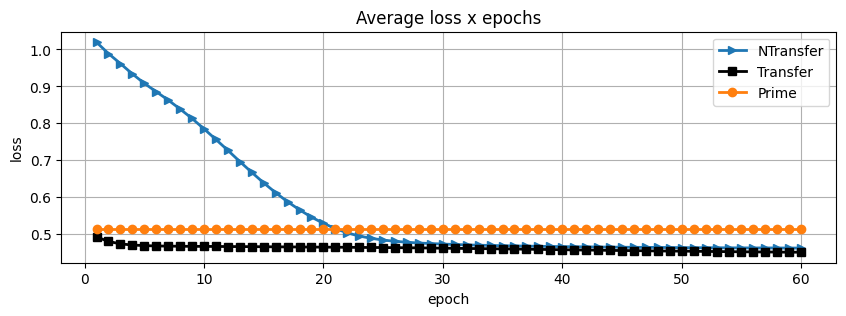

In [44]:
epocas = list(range(1, 61))
plt.plot(epocas, loss_listnl,'>-', label='NTransfer',linewidth = 2)
plt.plot(epocas, loss_list12,'-s', label='Transfer', color = 'black', linewidth = 2)
plt.plot(epocas, loss_prime, '-o', label = 'Prime', linewidth = 2)
plt.grid()
plt.legend();
plt.title('Average loss x epochs')
plt.xlabel('epoch')
plt.ylabel('loss')